# **2. VGG 16**

### Import Dataset

In [2]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="IaXBEeWUF7jj47qZcsVn")
project = rf.workspace("firstproject-qh0bd").project("plant-identification-41vnn")
version = project.version(1)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Plant-Identification-1 in folder:: 100%|██████████| 19216/19216 [00:06<00:00, 2979.92it/s]


### Import Library

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.image as mpimg

### Load and Display Image

/content/Plant-Identification-1/train/Alovera/20241106_142828_jpg.rf.f4741dc249d66ec0cf98889041b1f744.jpg


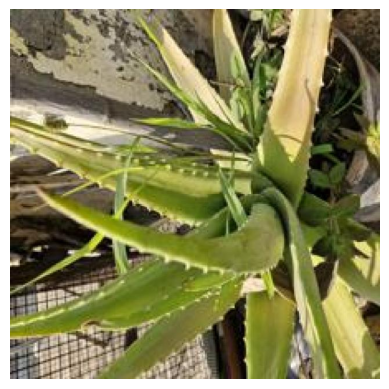

In [7]:
# Replace with your actual path
image_path = Path('/content/Plant-Identification-1/train/Alovera/').glob('*')
# Convert to a list and select the first image
image_list = list(image_path)

if image_list:  # Check if the list is not empty
    print(image_list[0])  # Print the first image path

    # Open the first image
    image = Image.open(str(image_list[0]))

    # Display the image within the notebook
    plt.imshow(image)
    plt.axis('off')  # Turn off axes
    plt.show()
else:
    print("No images found in the specified directory.")

### Dataset Configuration

In [8]:
# Data directory and parameters
data_dir = '/content/Plant-Identification-1/train'
img_size = 224
batch_size = 32

In [9]:
# ImageDataGenerator with augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split: 80% training, 20% validation
)

In [ ]:
# Training dataset generator
train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # One-hot encode labels
    subset='training',
    seed=123
)


Found 12925 images belonging to 22 classes.


In [ ]:
# Validation dataset generator
val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 3220 images belonging to 22 classes.


In [ ]:
# Display class names
class_names = train_ds.class_indices
print("Class Names:", list(class_names.keys()))

### Random Image Plot

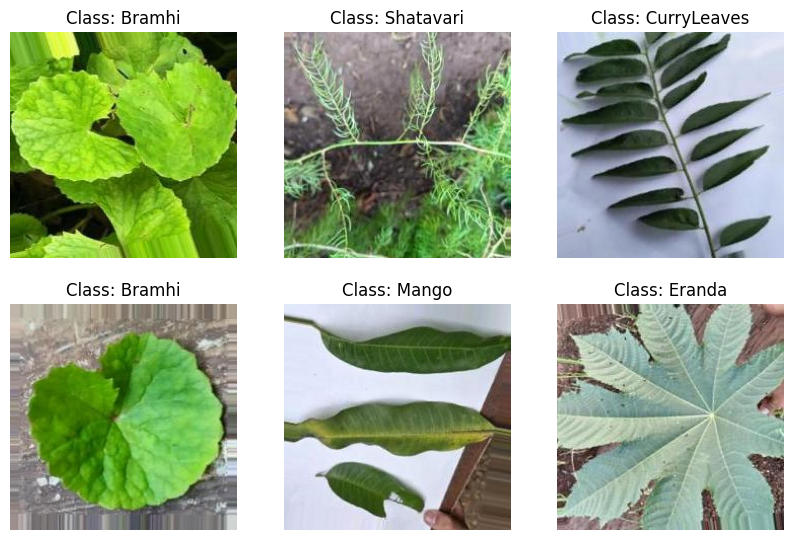

In [14]:
# Display sample images
plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(min(images.shape[0], 6)):
    ax = plt.subplot(3, 3, i + 1)
    image_to_display = images[i] * 255 if images[i].max() <= 1 else images[i]
    plt.imshow(image_to_display.astype("uint8"))
    predicted_class_index = np.argmax(labels[i])
    class_name = list(class_names.keys())[list(class_names.values()).index(predicted_class_index)]
    plt.title(f"Class: {class_name}")
    plt.axis("off")
plt.show()

### Model Defination

In [15]:
# VGG16 Model
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=22):
    input_tensor = Input(shape=input_shape)

    # Load VGG16 without top layers
    pretrained_model = tf.keras.applications.VGG16(
        include_top=False,
        input_tensor=input_tensor,
        pooling='avg',
        weights='imagenet'
    )

    # Freeze the pre-trained layers
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Add custom layers
    x = Flatten()(pretrained_model.output)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=pretrained_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [17]:
# Create the model
num_classes = len(class_names)
vgg16_model = create_vgg16_model(num_classes=num_classes)

In [18]:
vgg16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │              

 Total params: 14,988,630 (57.18 MB)

 Trainable params: 273,942 (1.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Training Model

In [19]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [20]:
# Train the model
epochs = 25
history = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/25


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


404/404 ━━━━━━━━━━━━━━━━━━━━ 105s 224ms/step - accuracy: 0.3983 - loss: 2.1837 - val_accuracy: 0.7239 - val_loss: 1.0160
Epoch 2/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.7378 - loss: 0.9677 - val_accuracy: 0.7599 - val_loss: 0.7921
Epoch 3/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accuracy: 0.8017 - loss: 0.7218 - val_accuracy: 0.8112 - val_loss: 0.6430
Epoch 4/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - accuracy: 0.8377 - loss: 0.5891 - val_accuracy: 0.8388 - val_loss: 0.5620
Epoch 5/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 71s 174ms/step - accuracy: 0.8548 - loss: 0.5070 - val_accuracy: 0.8404 - val_loss: 0.5387
Epoch 6/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.8798 - loss: 0.4243 - val_accuracy: 0.8512 - val_loss: 0.5166
Epoch 7/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 83s 173ms/step - accuracy: 0.8903 - loss: 0.3879 - val_accuracy: 0.8826 - val_loss: 0.4252
Epoch 8/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 76s 186ms/step - accuracy: 0.9082 - loss: 0.3335 - v

In [22]:
# Evaluate the model
print("Evaluating model...")
val_loss, val_accuracy = vgg16_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.8740 - loss: 0.4448
Validation Accuracy: 88.26%


### Prediction

In [23]:
# Save class indices as JSON
import json
class_indices = {v: k for k, v in train_ds.class_indices.items()}
json.dump(class_indices, open('class_indices.json', 'w'))

In [24]:
# Predict a single image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

In [25]:
def predict_image_class_with_probabilities(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_probabilities = {class_name: round(prob * 100, 2) for class_name, prob in zip(class_indices.values(), predictions[0])}
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    predicted_class_prob = class_probabilities[predicted_class_name]
    return predicted_class_name, predicted_class_prob, class_probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


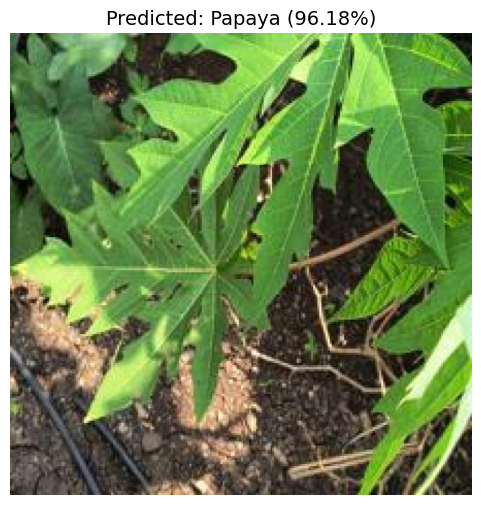

In [48]:
image_path = '/content/Plant-Identification-1/test/Papaya/IMG_20241105_135225472_jpg.rf.da9f1c2299d7969d42ce37def2abe65e.jpg'
predicted_class_name, predicted_class_prob, class_probabilities = predict_image_class_with_probabilities(vgg16_model, image_path, class_indices)

# Display results
img = mpimg.imread(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class_name} ({predicted_class_prob}%)", fontsize=14)
plt.show()

### Class Probability

In [49]:
print("Class Probabilities:")
for class_name, prob in sorted(class_probabilities.items()):
    print(f"{class_name}: {prob:.2f}%")

print("\nPredicted Class:", predicted_class_name)
print(f"Probability of Predicted Class: {predicted_class_prob:.2f}%")

Class Probabilities:
Adulsa: 0.80%
Alovera: 0.01%
Amla: 0.00%
Banana: 0.01%
BeetalLeaf(Pan): 0.00%
Bramhi: 0.00%
CurryLeaves: 0.00%
Drumstick: 0.01%
Eranda: 2.33%
Gokarna: 0.04%
Hibiscus: 0.00%
Jamun(IndianBlackberry): 0.02%
Mango: 0.09%
Neem: 0.25%
Onion: 0.01%
Panfuti: 0.00%
Papaya: 96.18%
Satynashi: 0.01%
Shatavari: 0.00%
Sugarcane: 0.00%
Tandulja: 0.04%
TouchMeNot: 0.18%

Predicted Class: Papaya
Probability of Predicted Class: 96.18%


### Graph Plot

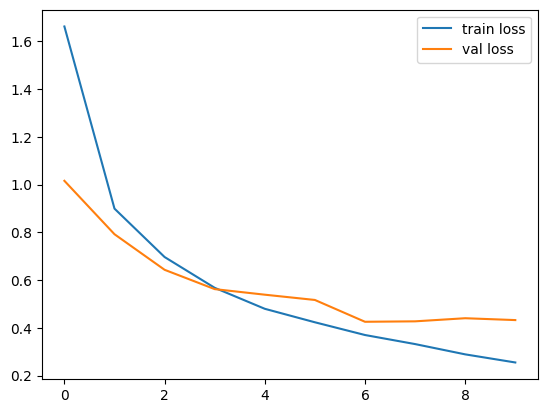

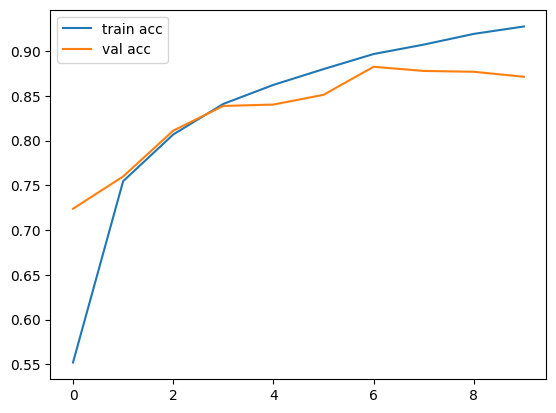

In [45]:
# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Save Model

In [50]:
# Save the VGG16 model in HDF5 format
vgg16_model.save('vgg16_plant_identification_model.h5')

# Download the saved model
from google.colab import files
files.download('vgg16_plant_identification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Save the model weights to an HDF5 file with the correct extension
vgg16_model.save_weights('vgg16_plant_identification_weights.weights.h5')

# Download the weights file
from google.colab import files
files.download('vgg16_plant_identification_weights.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>